# LSTM

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
valid = pd.read_csv("valid.csv")

train.loc[train["review_score"]==-1, "review_score"]=0
test.loc[test["review_score"]==-1, "review_score"]=0
valid.loc[valid["review_score"]==-1, "review_score"]=0

### Finding the length of the longest review in the dataset (theoretically Steam allows reviews with max 8000 characters)

In [2]:
train["seq_length"] = train["review_text"].apply(lambda x : len(x.split()))

In [5]:
train["seq_length"].describe()

count    43230.000000
mean        74.154962
std        127.088261
min          0.000000
25%         12.000000
50%         31.000000
75%         80.000000
max       1570.000000
Name: seq_length, dtype: float64

### Some reviews are very long but most are below 100 words. To improve training speed in this exercise, I'll drop the examples that are longer than 100 words.

*Note: Previously I tried to train the model on 1600-token-long sequences (longer than the longest review). The training took a long time and the model's prediction quality was very low.*

In [7]:
#train.drop(train["seq_length"]>200, inplace=True)
train.drop(train[train.seq_length > 200].index, inplace=True)

In [8]:
train["seq_length"].describe()

count    39571.000000
mean        44.135124
std         44.780534
min          0.000000
25%         11.000000
50%         27.000000
75%         62.000000
max        200.000000
Name: seq_length, dtype: float64

In [9]:
import tensorflow as tf

SEQ_PADDED_LENGTH = 200
VOCABULARY_SIZE = 4000
vectorizer = tf.keras.layers.TextVectorization(output_sequence_length=SEQ_PADDED_LENGTH, max_tokens=VOCABULARY_SIZE)
vectorizer.adapt(train["review_text"])

In [10]:
len(vectorizer.get_vocabulary())

4000

In [11]:
train["vectorized"] = train["review_text"].apply(vectorizer)

In [12]:
test["vectorized"] = test["review_text"].apply(vectorizer)
valid["vectorized"] = valid["review_text"].apply(vectorizer)

In [13]:
from keras.optimizers import Adam
import keras.layers as layers
import keras


def create_model():
    input_layer = layers.Input(shape=(SEQ_PADDED_LENGTH,))
    embedding_layer = layers.Embedding(input_dim=VOCABULARY_SIZE+1, output_dim=128, input_length=SEQ_PADDED_LENGTH)(input_layer)
    #lstm_layer = layers.LSTM(64)(embedding_layer)
    lstm_layer = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedding_layer)
    dropout_layer = layers.Dropout(0.5)(lstm_layer)
    lstm_layer_2 = layers.Bidirectional(layers.LSTM(64))(dropout_layer)
    output_layer = layers.Dense(1,activation="sigmoid")(lstm_layer_2)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    return model
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          512128    
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129   

In [14]:
train.iloc[120]["vectorized"].shape

TensorShape([200])

In [15]:
train.iloc[120]["vectorized"].get_shape().as_list()

[200]

In [16]:
train.iloc[120]["vectorized"]

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([ 225, 1120,    2,  113,    1, 1816,    3,  108,   97, 1417,   23,
         12,   52,   19,  257,   10,    3,   52,   34,    8,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Some reviews don't contain text so after removing punctuation and special characters they become empty strings. Such texts have to be removed from the training dataset.

In [17]:
train["shapes"] = train["vectorized"].apply(lambda x : x.get_shape().as_list()[0])
train["shapes"].value_counts()

shapes
200    39452
0        119
Name: count, dtype: int64

In [18]:
train.drop(train[train["vectorized"].map(lambda x : x.get_shape().as_list()[0])!=SEQ_PADDED_LENGTH].index, inplace=True)
train["shapes"].value_counts()

shapes
200    39452
Name: count, dtype: int64

In [19]:
#valid.drop(valid[valid["vectorized"].map(lambda x : x.get_shape().as_list()[0])!=1600].index, inplace=True)

empty_valid = valid[valid["vectorized"].map(lambda x : x.get_shape().as_list()[0])==0]
empty_valid.head()

,Unnamed: 0,review_text,review_score,vectorized
42,4552590,!!!,1,()
124,5286261,.,1,()
259,4934066,........,1,()
468,5584357,.,1,()
717,2172088,=],1,()


"0" marks masked positons, so empty fields in the test dataset can be filled with this character.

In [20]:
#test.loc[test["vectorized"].map(lambda x : x.get_shape().as_list()[0])!=SEQ_PADDED_LENGTH,"vectorized"] = tf.zeros((SEQ_PADDED_LENGTH,), dtype=tf.dtypes.int64)
#valid.loc[valid["vectorized"].map(lambda x : x.get_shape().as_list()[0])!=SEQ_PADDED_LENGTH,"vectorized"] = tf.zeros((SEQ_PADDED_LENGTH,), dtype=tf.dtypes.int64)
#empty_valid["vectorized"] = tf.zeros((len(empty_valid.index),1600), dtype=tf.dtypes.int64)
#empty_test["vectorized"] = tf.zeros((len(empty_test.index),1600), dtype=tf.dtypes.int64)

#empty_valid["vectorized"].iloc[0]

def vector_fix(x):
    if x.get_shape().as_list()[0]==SEQ_PADDED_LENGTH:
        return x
    return tf.zeros((SEQ_PADDED_LENGTH,), dtype=tf.dtypes.int64)

test["vectorized"] = test["vectorized"].apply(vector_fix)
valid["vectorized"] = valid["vectorized"].apply(vector_fix)

In [21]:
#train["vectorized"] = train["vectorized"].apply(lambda x : x.numpy())
#valid["vectorized"] = valid["vectorized"].apply(lambda x : x.numpy())
#test["vectorized"] = test["vectorized"].apply(lambda x : x.numpy())

In [22]:
train.iloc[0]["vectorized"]

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  41,   50, 1864,   20,    2,  201,    3,   90,   27,   98,   47,
          4,  243,   50,  381,  184,    7,  139,  408,   71,   10,    5,
        120,   14,    2,  688,    2,    3,    9,   48,    1,   30,   85,
         31,    7,  314,   87,   12,  577,    6,  494,   10,    3,   63,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [23]:
#train_y = np.stack(train["review_score"].values)
train_y = np.stack(train["review_score"].values)
valid_y = np.stack(valid["review_score"].values)

test_y = np.stack(test["review_score"].values)

###
#train_x =  np.stack(train["vectorized"].values)
train_x =  np.stack(train["vectorized"].values)

test_x = np.stack(test["vectorized"].values)
valid_x =  np.stack(valid["vectorized"].values)


#callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=3)

Epoch 1/3
1233/1233 [==============================] - 288s 230ms/step - loss: 0.4453 - accuracy: 0.7923 - val_loss: 0.3532 - val_accuracy: 0.8514
Epoch 2/3
1233/1233 [==============================] - 289s 235ms/step - loss: 0.3145 - accuracy: 0.8669 - val_loss: 0.3272 - val_accuracy: 0.8519
Epoch 3/3
1233/1233 [==============================] - 289s 234ms/step - loss: 0.2684 - accuracy: 0.8875 - val_loss: 0.3216 - val_accuracy: 0.8635


In [24]:
model.save("lstm_model.keras")

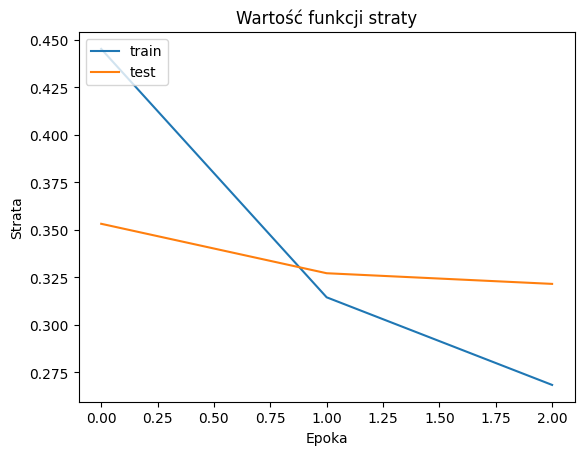

In [25]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wartość funkcji straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['train', 'test'], loc='upper left')

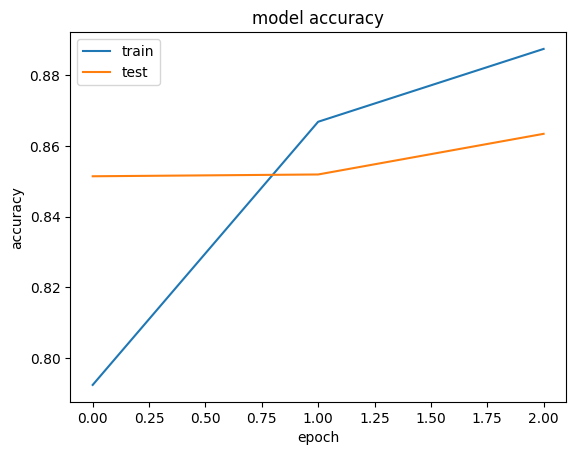

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Further model training

In [27]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1, restore_best_weights=True)
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=5, callbacks=[callback])

Epoch 1/5
1233/1233 [==============================] - 273s 222ms/step - loss: 0.2408 - accuracy: 0.9019 - val_loss: 0.3459 - val_accuracy: 0.8605
Epoch 2/5
1233/1233 [==============================] - 272s 221ms/step - loss: 0.2180 - accuracy: 0.9105 - val_loss: 0.3498 - val_accuracy: 0.8656


In [28]:
model.save("lstm_model_v2.keras")

### Model testing (manually on random samples) and evaluation

In [31]:
import tensorflow as tf
def test_review_text(sentence):
    vectorized = vectorizer(sentence)
    reshaped = tf.reshape(vectorized,shape=(1,200))
    #print(vectorized.shape)
    score = float(model(reshaped))
    score_rounded = round(score)
    print(score)
    if score_rounded==0:
        print("Negative review")
    else:
        print("Positive review")

In [32]:
test_review_text("A buggy, uninspired mess")

0.02259424328804016
Negative review


In [33]:
test_review_text("This game is bad")

0.066298708319664
Negative review


In [34]:
test_review_text("This game destroyed my life")

0.9277510643005371
Positive review


In [35]:
test_review_text("Best game I've ever played")

0.990617036819458
Positive review


In [36]:
test_review_text("Fun cooperative play with scalable difficulty. Rapid path to get into a game with friends or open public games. ")

0.9053470492362976
Positive review


In [37]:
test_review_text("Deliriously buggy. Fun if/when it works properly. Wait and see if they actually QA the next few patches before you play.")

0.3265230357646942
Negative review


In [38]:
test["model_predictions"] = model(np.stack(test["vectorized"].values))

In [39]:
test["model_predictions"] = test["model_predictions"].apply(lambda x : round(float(x)))

In [40]:
def get_metrics():
    df = test
    predictions = df["model_predictions"].to_numpy()
    true_values = df["review_score"].to_numpy()
    accuracy = np.sum(np.rint(predictions) == true_values)/len(true_values)
    TN_count = len(df.query("`review_score`==0 and `model_predictions`==0").index)
    TP_count = len(df.query("`review_score`==1 and `model_predictions`==1").index)
    FP_count = len(df.query("`review_score`==0 and `model_predictions`==1").index)
    FN_count = len(df.query("`review_score`==1 and `model_predictions`==0").index)
    precision = TP_count/(TP_count+FP_count)
    recall = TP_count/(TP_count+FN_count)
    F1_score = (2*precision*recall)/(precision+recall)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {F1_score:.2f}")
get_metrics()

Accuracy: 0.86
Precision: 0.97
Recall: 0.86
F1 Score: 0.91
